In [1]:
from WeightsProperties import *
from CaffeVPLUtils import *
from scipy.stats import f_oneway, ttest_ind, ttest_rel, kruskal, kstest, ks_2samp, \
mannwhitneyu, chi2_contingency,chisquare, skew, wilcoxon
%matplotlib inline
from scipy.stats import pearsonr, sem
from statsmodels.formula.api import ols
import statsmodels.api as sm
import tqdm
panel_font = dict(fontsize=18, fontweight=3)
plt.rc('text', usetex=False)
#fig_dir = 'C:/Users/KevinW/OneDriveUCL/OneDrive - University College London/perceptual learning/paper_figs/'

import seaborn.apionly as sns

from matplotlib import rc
fig_dir = 'figs/'
panel_font = dict(fontsize=15, fontweight=3)
plt.rc('font',family='Times')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 18
#plt.rc('text', usetex=True)
rc('mathtext', default='regular') 
plt.rcParams['axes.axisbelow']=True

C:\Anaconda64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def correlate_two(ax, f1, f2, **kwargs):
    
    f1 = f1/(np.abs(f1).max())
    f2 = f2/(np.abs(f2).max())

    ax.scatter(f1, f2, **kwargs)
    cor, p = pearsonr(f1,f2)
    if np.all(f1>=0) :
        ax.set_xlim([0, 1.2])
    else:
        ax.set_xlim([-1,1.2])
    if np.all(f2>=0):
        ax.set_ylim([0, 1.2])
    else:
        ax.set_ylim([-1,1.2])
    ax.text(0.05,0.95,'r: %.2f, p=%.2g' % (cor, p), 
            horizontalalignment='left',
            verticalalignment='top',
           transform=ax.transAxes)


def plot_env(ax, x, y_mean, y_std = None, color='k', label=None, std_scale = 1, alpha = 1.0, **kwargs):
    '''
    plot an envelope
    '''
    if y_std is None:
        assert y_mean.ndim == 2
        y_std = y_mean.std(1)
        y_mean = y_mean.mean(1)
    else:
        assert y_mean.ndim == 1
        assert y_std.ndim == 1


    ax.plot(x, y_mean, label=label, color = color, alpha = alpha, **kwargs)

    ax.fill_between(x, 
             y_mean - y_std/std_scale,
             y_mean + y_std/std_scale, 
             color=color, alpha = 0.3*alpha)
    
def lookup(df_in, **kwargs):
    
    df = df_in.copy()
    for k, v in kwargs.items():
        df = df[np.abs(df[k]-v)<0.001]
    return df, df.index.tolist()
    
    

def scatter_errorbar(ax, x, y, bins, plot = True, **kwargs):

    count, _ = np.histogram(x, bins=bins)
    bin_idx = np.digitize(x, bins)-1
    bin_centers = (bins[1:]+bins[:-1])/2.0
    
    bin_vals = [y[bin_idx == i] for i in range(len(bins)-1)]
    
    means = np.array(map(np.mean, bin_vals))
    sems  = np.array(map(sem, bin_vals))
    
    means[np.isnan(means)] = 0.0
    sems[np.isnan(sems)] = 0.0
    if plot:
        ax.errorbar(bin_centers, means, sems, **kwargs)
    
    return means, sems, bin_vals



In [3]:
weights_dir = 'models/'
tuning_dir  = 'data/tuning'
var_param_name = 'd_angle'

sense_measures = dict()
sense_measures['mean']          = lambda r_mean, r_var, r_grad, r_cov: r_mean
sense_measures['n_mean']          = lambda r_mean, r_var, r_grad, r_cov: r_mean/r_mean.max(0)[None,:]
sense_measures['var']           = lambda r_mean, r_var, r_grad, r_cov: r_var
sense_measures['std']           = lambda r_mean, r_var, r_grad, r_cov: np.sqrt(r_var)
sense_measures['grad']          = lambda r_mean, r_var, r_grad, r_cov: r_grad
sense_measures['mean_var']          = lambda r_mean, r_var, r_grad, r_cov: r_mean/(1e-4+r_var)
sense_measures['abs_grad']      = lambda r_mean, r_var, r_grad, r_cov: np.abs(r_grad)

weights_file = "A_angle_d_angle_['angle', 'wave']_[10.0,0.5,-5.0]_15_[*.0_10.0_0.2]_[0.0_0.0]_20_0.0001_0.9_0.0_0_1000_6"

w_df = load_weights_df(weights_file,tuning_dir,var_param_name)
diff_values = np.sort(w_df['d_angle'].unique())
len(w_df)



60

In [4]:
w_df.iloc[0].w_file

"data/tuning/A_angle_d_angle_['angle', 'wave']_[10.0,0.5,-5.0]_15_[0.0_10.0_0.2]_[0.0_0.0]_20_0.0001_0.9_0.0_0_1000_6_07-20-22-36-51_0.5_iter_1000.tuning"

In [5]:
dfs = []
qfs = []
for wf in tqdm.tqdm(w_df['w_file']):
    
    tf = TuningFeatures(wf, full_cov=True)
    tf.load_tuning()
    tf.compute_features(sense_measures, smoothing = 1)
    noise = tf.attrs['noise']
    angle = tf.attrs['angle']
    wave = tf.attrs['wave']
    ctrst = tf.attrs['ctrst']
    tf.measure_test(angle,1)
    
    wf0 = "models/AlexNet/weights_1c.caffemodel"
    tf0 = TuningFeatures(wf0, noise = noise, angle = angle, ctrst = ctrst, wave = wave, full_cov=True)
    tf0.load_tuning()
    tf0.compute_features(sense_measures, smoothing = 1)
    tf0.measure_test(angle,1)
        
    df = tf-tf0

    dfs.append(df)
    tf.raw_tc.close()
    tf0.raw_tc.close()

100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.36it/s]


In [6]:
nangle = 100
angles = np.linspace(-90.0,90.0,nangle)
blobs = ['norm1','norm2','conv3','conv4','conv5']
nblob = len(blobs)
diffs = np.sort(w_df.d_angle.unique())
ndiff = len(diffs)

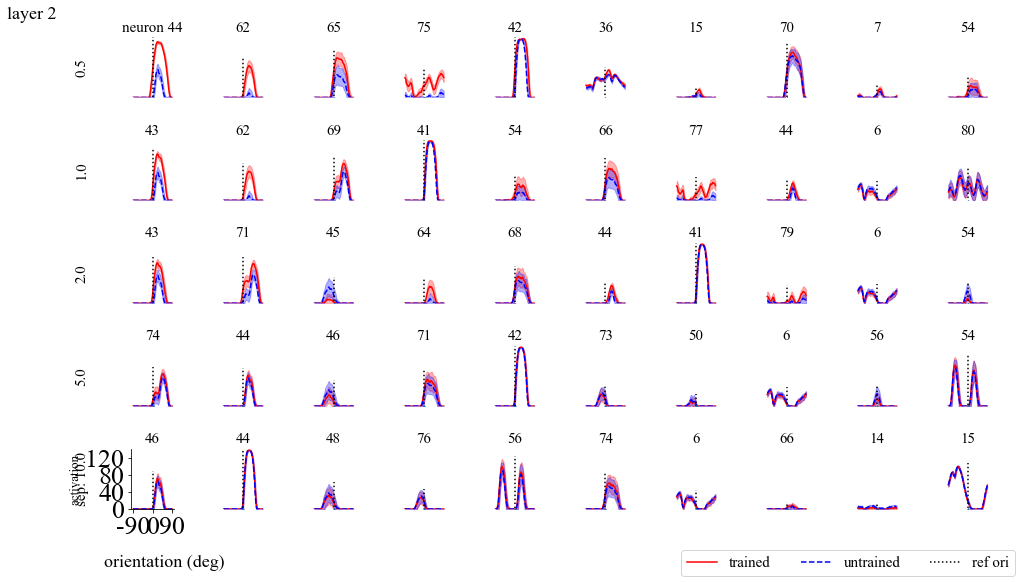

In [7]:
fig, axes = plt.subplots(5,10,figsize=(15,8))

for di, diff in enumerate(diff_values):
    _, idx = lookup(w_df, angle = 60.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    idx = idx[0]
    
    blob = 'norm2'

    
    alphas = abs(dfs[idx].dt[blob]['mean']**2)
    alphas = dfs[idx].dt_test[blob]['grad']

    nn = len(alphas)
    A_common = np.where(dfs[idx].A_common[blob])[0]
    B_common = np.where(dfs[idx].B_common[blob])[0]
    top_idx = np.argsort(alphas)[-1:-11:-1]

    for ni, n in enumerate(top_idx):
        ax = axes[di][ni]

        mean_array = dfs[idx].A.t[blob]['mean'][:,A_common[n]]
        std_array  = dfs[idx].A.t[blob]['std'][:,A_common[n]]
        plot_env(ax, angles, mean_array, std_array, std_scale=1, color='r', label = 'trained');

        mean_array = dfs[idx].B.t[blob]['mean'][:,B_common[n]]
        std_array  = dfs[idx].B.t[blob]['std'][:,B_common[n]]
        plot_env(ax, angles, mean_array, y_std=std_array, std_scale=1, color = 'b', ls = '--',  label='untrained');
        ax.plot([-10.0], '^', ms = 10)
        ylim = ax.get_ylim()

        ax.plot([0.0,0.0], ylim,':k', label='ref ori')
        if di == 0 and ni == 0:
            ax.set_title('neuron %d' %n, fontsize =15)
        else:
            ax.set_title(n, fontsize =15)
        ax.set_ylim([0,140])
        if not(di == 4 and ni == 0):
            ax.set_axis_off()
        else:
            cool_spines(ax)
            ax.set_yticks(np.arange(0,151,40))
            ax.set_yticklabels(np.arange(0,151,40), fontsize='x-large')

axes[-1,0].set_ylabel('activation', fontsize = 13)
axes[-1,0].set_xticks([-90,0,90])
axes[-1,0].set_xticklabels([-90,0,90],fontsize='x-large')
fig.tight_layout(rect=[0.05,0.03,0.95,1], h_pad=0.1, w_pad = 0.0)      
axes[-1,0].text(-1,0.5,'sep: ' +str(diff_values[-1]), 
    horizontalalignment='right',
    verticalalignment='center',
    fontsize = 15, 
   transform=axes[-1,0].transAxes, rotation=90) 

for di in range(4):
        axes[di,0].text(-1,0.5, str(diff_values[di]), 
                horizontalalignment='right',
                verticalalignment='center',
                fontsize = 15, 
               transform=axes[di,0].transAxes, rotation=90)


ax.legend(loc='center right', bbox_to_anchor=[0.95,0.025],ncol=3,
          bbox_transform=fig.transFigure, prop={'size':15})
fig.text(0.1,0.025,'orientation (deg)', va='center')
fig.text(0.01,0.99,'layer '+str(blob[-1]), va='top', ha='left')
#fig.savefig(fig_dir + 'tuning_examples_change_grad_layer' + str(blob[-1]) + '.tiff', dpi=300)

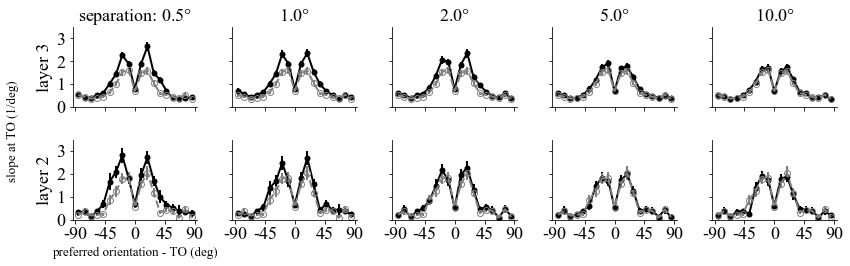

In [12]:
feat1 = 'ori'
feat2 = 'abs_grad'

nbins = 20
bins = np.linspace(-90.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = [blobs[i] for i in [1,2]]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: 0.5$\degree$')


    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di]
        axes[nblob-1-bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t_test[blob][feat2]/dfs[i].A.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, all_feat1_vals, all_feat2_vals, bins, 
                                              lw=2.0, color='k',marker='o',markeredgecolor='none');


        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t_test[blob][feat2]/dfs[i].B.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, all_feat1_vals, all_feat2_vals, bins, 
                                                lw=2, color='gray', ls = '--', marker='o', fillstyle = 'none');
        '''
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05/13/4:
                ax.plot([bin_centers[bini]], [2.8], '*', color = 'k')
        '''
        ax.set_ylim([0,3.5])
        ax.set_yticks([0,1,2,3])
        #ax.set_xlim([-90.0,90.0])
        ax_xticks(ax, np.arange(-90,91,45), np.arange(-90,91,45))
        ##ax_yticks(ax, np.arange(1,4.0), np.arange(1,4.0))
        cool_spines(ax)


fig.tight_layout()
fig.tight_layout(rect=[0.02,0.04,1,1])
axes[-1,0].set_xlabel('preferred orientation - TO (deg)', fontsize = 13)
fig.text(0.01, 0.5, 'slope at TO (1/deg)', va='center', rotation=90, fontsize = 13)
#fig.savefig(fig_dir + 'slope_TO_two_side.tiff', dpi = 300)


In [14]:
stats_table = pd.DataFrame(columns=[0.5,1.0,2.0,5.0, 10.0], index=[3,2])

In [15]:
stats_table

,0.5,1.0,2.0,5.0,10.0
3,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


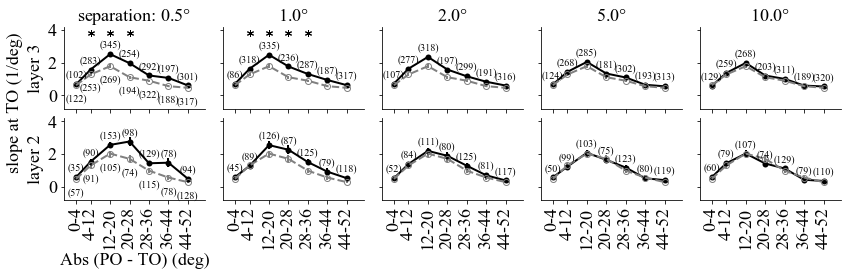

In [16]:
feat1 = 'ori'
feat2 = 'abs_grad'
stats_table = pd.DataFrame(columns=[0.5,1.0,2.0,5.0, 10.0], index=[3,2])
bins = np.array([0,4,12,20,28,36,44,52])
nbins = len(bins)-1

bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[2:0:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
xtickslabels = map(lambda x: '%.0f-%.0f' %(x[0],x[1]), np.c_[bins[:-1],bins[1:]])

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])


    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t_test[blob][feat2]/dfs[i].A.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                              lw=2.0, color='k',marker='o', markeredgecolor='none',
                                             elinewidth=2,);


        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t_test[blob][feat2]/dfs[i].B.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                                elinewidth=2,
                                                lw=2.0, color='gray', ls = '--', marker='o', fillstyle = 'none');
        ax.set_ylim([-0.8,4.2])
        ax_yticks(ax, range(0,6,2), range(0,6,2))
        ax.set_xlim([-3.0,55.0])
        ax.set_xticks(bin_centers)
        ax.set_xticklabels(xtickslabels, rotation=90)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        if di == 0:
            for bini in range(nbins):
                ax.text(bin_centers[bini],np.mean(untrained_vals[bini])-1.0,
                        '(%d)' % len(untrained_vals[bini]), color = 'k', fontsize = 10, ha = 'center')
        for bini in range(nbins):
            ax.text(bin_centers[bini],np.mean(trained_vals[bini])+0.4,
                    '(%d)' % len(trained_vals[bini]), color = 'k', fontsize = 10, ha = 'center')
            
            
        slope_df = pd.DataFrame(columns=['slope','bin', 'train'])
        for bini in range(nbins):
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=untrained_vals[bini], train=0)))
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=trained_vals[bini], train=1)))
        model = ols('slope ~ C(bin) * (train)', data = slope_df).fit()
        anova_res = sm.stats.anova_lm(model)
        stats_text =  'F(%d,%d)=%.2f p=%.2g' % (anova_res['df']['C(bin):train'], 
                                        anova_res['df']['Residual'],
                                        anova_res['F']['C(bin):train'],
                                        anova_res['PR(>F)']['C(bin):train'])
        stats_table[diff][int(blob[-1])] = stats_text
        if anova_res['PR(>F)']['C(bin):train']<0.01:
            for bini in range(nbins):
                F_value, p_value = mannwhitneyu(trained_vals[bini], untrained_vals[bini])
                if p_value < 0.01/8:
                    ax.plot([bin_centers[bini]], [3.8], marker=(6,2,0), color = 'k', ms=7)
        cool_spines(ax)

fig.tight_layout()
axes[-1,0].set_xlabel('Abs (PO - TO) (deg)')
fig.text(0.01, 0.6, 'slope at TO (1/deg)', va='center', rotation=90)
fig.tight_layout(rect=[0.01,-0.05,1,1], h_pad=0.2, w_pad=0.5)

#fig.savefig(fig_dir + 'fig_6-1.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_6-1.svg', dpi = 300)

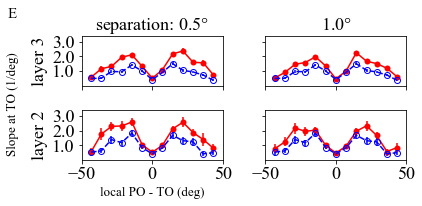

In [17]:
feat1 = 'local_ori'
feat2 = 'abs_grad'

nbins = 14
bins = np.linspace(-47.0,47.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[1:3]
this_diffs = [diffs[i] for i in [0,1]]
nblob = len(this_blobs)
ndiff = len(this_diffs)

fig, axes = plt.subplots(nblob, ndiff, figsize=(6,3), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])


    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di]
        axes[nblob-1-bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t_test[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t_test[blob][feat2]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, all_feat1_vals, all_feat2_vals, bins, 
                                              lw=1.5, color='r',marker='o', markeredgecolor='none');


        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t_test[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t_test[blob][feat2]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, all_feat1_vals, all_feat2_vals, bins, 
                                                lw=1.5, color='b', ls = '--', marker='o', fillstyle = 'none');
        '''
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05/13/4:
                ax.plot([bin_centers[bini]], [2.8], '*', color = 'k')
        '''
        ax.set_ylim([0,3.4])
        ax.set_xlim([-50.0,50.0])
        ax_yticks(ax, np.arange(1,4.0), np.arange(1,4.0))



fig.tight_layout()
fig.tight_layout(rect=[0.02,0.04,1,1])
axes[-1,0].set_xlabel('local PO - TO (deg)', fontsize = 13)
fig.text(0.01, 0.5, 'Slope at TO (1/deg)', va='center', rotation=90, fontsize = 13)
fig.text(0.01,0.9, 'E', **panel_font)
#fig.savefig(fig_dir + 'slope_TO_local_two_side.tiff', dpi = 300)


                     df       sum_sq     mean_sq          F        PR(>F)
C(bin)              6.0   536.437431   89.406238  33.208403  3.936285e-38
C(train)            1.0   104.491396  104.491396  38.811524  5.807409e-10
C(bin):C(train)     6.0    56.999949    9.499991   3.528608  1.781732e-03
Residual         1786.0  4808.407794    2.692278        NaN           NaN
                     df       sum_sq     mean_sq          F        PR(>F)
C(bin)              6.0   787.566676  131.261113  77.938136  1.674519e-93
C(train)            1.0   167.456247  167.456247  99.429507  3.317122e-23
C(bin):C(train)     6.0    54.955568    9.159261   5.438441  1.285895e-05
Residual         5082.0  8558.954686    1.684171        NaN           NaN
                     df       sum_sq    mean_sq          F        PR(>F)
C(bin)              6.0   474.911911  79.151985  32.831092  1.034060e-37
C(train)            1.0    41.278464  41.278464  17.121706  3.667757e-05
C(bin):C(train)     6.0    29.771375   4.

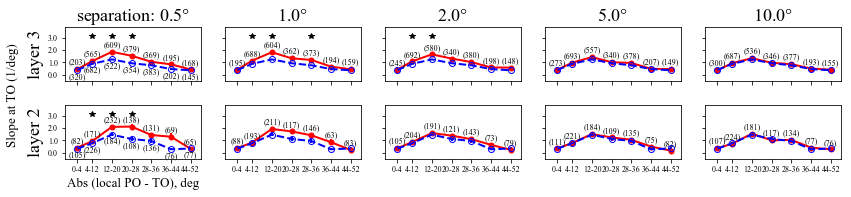

In [18]:
feat1 = 'local_ori'
feat2 = 'abs_grad'

bins = np.array([0,4,12,20,28,36,44,52])
nbins = len(bins)-1

bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[1:3]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
xtickslabels = map(lambda x: '%.0f-%.0f' %(x[0],x[1]), np.c_[bins[:-1],bins[1:]])

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,3), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])


    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di]
        axes[nblob-1-bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t_test[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t_test[blob][feat2]/dfs[i].A.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                              lw=2.0, color='r',marker='o', markeredgecolor='none');


        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t_test[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t_test[blob][feat2]/dfs[i].B.t_test[blob]['mean'].max()*100
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                                lw=2.0, color='b', ls = '--', marker='o', fillstyle = 'none');
        for bini in range(nbins):
            F_value, p_value = mannwhitneyu(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.01/8:
                if di == 1 and bi ==0: continue
                ax.plot([bin_centers[bini]], [3.2], '*', color = 'k')
        ax.set_ylim([-0.5,3.9])
        ax_yticks(ax, np.arange(0,4.0), np.arange(0,4.0))
        ax.set_xlim([-3.0,52.0])
        ax.set_xticks(bin_centers)
        ax.set_xticklabels(xtickslabels)
        ax.tick_params(labelsize=8)
        
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        if di == 0:
            for bini in range(nbins):
                ax.text(bin_centers[bini],np.mean(untrained_vals[bini])-0.7,
                        '(%d)' % len(untrained_vals[bini]), color = 'k', fontsize = 8, ha = 'center')
        for bini in range(nbins):
            ax.text(bin_centers[bini],np.mean(trained_vals[bini])+0.4,
                    '(%d)' % len(trained_vals[bini]), color = 'k', fontsize = 8, ha = 'center')
        slope_df = pd.DataFrame(columns=['slope','bin', 'train'])
        for bini in range(nbins):
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=untrained_vals[bini], train=0)))
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=trained_vals[bini], train=1)))
        model = ols('slope ~ C(bin) * C(train)', data = slope_df).fit()
        #print model.summary()
        print sm.stats.anova_lm(model)
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.05,1,1])
axes[-1,0].set_xlabel('Abs (local PO - TO), deg', fontsize =13)
fig.text(0.01, 0.5, 'Slope at TO (1/deg)', va='center', rotation=90, fontsize = 13)
#fig.savefig(fig_dir + 'slope_TO_local_low.tiff', dpi = 300)

In [19]:
stats_table

,0.5,1.0,2.0,5.0,10.0
3,"F(6,3425)=5.17 p=2.7e-05","F(6,3417)=2.99 p=0.0065","F(6,3356)=1.90 p=0.077","F(6,3317)=0.47 p=0.83","F(6,3330)=0.39 p=0.89"
2,"F(6,1311)=1.71 p=0.11","F(6,1303)=0.82 p=0.55","F(6,1284)=0.15 p=0.99","F(6,1283)=0.24 p=0.96","F(6,1272)=0.51 p=0.8"


## distribution of preferred orientation

Fig 4

Ghose, G. M., Yang, T., & Maunsell, J. H. R. (2002). Physiological Correlates of Perceptual Learning in Monkey V1 and V2. J Neurophysiol, 87(4), 1867–1888. https://doi.org/10.1152/jn.00690.2001

norm2 0.5
ks:  0.038271252557 0.398062018538 1078
x:   65.9628942486 7.09862756117e-10
x2: (8, n=2170)=27.4 p=0.004
conv3 0.5
ks:  0.0352566137726 0.058913839712 2787
x:   111.975242196 7.38115267919e-19
x2: (8, n=5635)=29.3 p=0.002
norm2 1.0
ks:  0.023113250386 0.930063241349 1089
x:   28.0798898072 0.0031473566175
x2: (8, n=2181)=11.4 p=0.41
conv3 1.0
ks:  0.0277658496622 0.219880114291 2839
x:   59.2472701656 1.27895941277e-08
x2: (8, n=5687)=17.2 p=0.1
norm2 2.0
ks:  0.0125747628014 0.999993424805 1103
x:   14.5883952856 0.202126250261
x2: (8, n=2195)=5.2 p=0.92
conv3 2.0
ks:  0.0144035959006 0.927594233411 2845
x:   30.583831283 0.00128213988123
x2: (8, n=5693)=4.4 p=0.96
norm2 5.0
ks:  0.0113445378151 0.999999703376 1105
x:   9.58823529412 0.567760909583
x2: (8, n=2197)=2.6 p=1
conv3 5.0
ks:  0.00804634584625 0.999986240605 2845
x:   27.0576449912 0.00450398047683
x2: (8, n=5693)=2.5 p=1
norm2 10.0
ks:  0.020999000999 0.967540323952 1100
x:   16.8072727273 0.113707085435
x2: (8, 

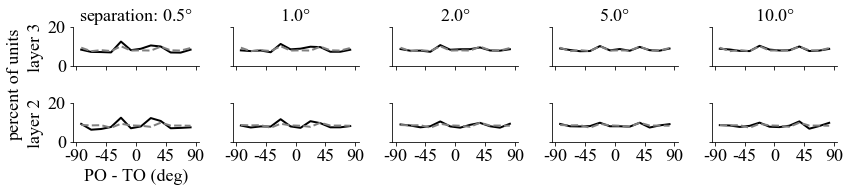

In [20]:
feat1 = 'ori'
nbins = 13
bins = np.linspace(-90.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[1:3]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
fig, axes = plt.subplots(nblob, ndiff, figsize=(12,3), sharex = True, sharey = True)
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        print blob, diff
        
        ax = axes[nblob-1-bi, di]
        axes[nblob-1-bi, 0].set_ylabel('layer ' + str(blob[-1]))

        
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.plot(bin_centers, counts/counts.sum()*100, 
               color = 'k', linewidth = 2)
        #ax.plot([-95,95],[100.0/(nbins-1), 100.0/(nbins-1)],'k', lw = 2)
        trained_counts = counts.copy()

        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat2_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        
        ax.plot(bin_centers, counts/counts.sum()*100, 
               color = 'gray', ls = '--', lw = 2)
        #ax.plot([-diff, -diff],[0,0.25], ':k')
        #ax.plot([diff, diff],[0,0.25], ':k')
        
        d_value, pv = ks_2samp(all_feat1_vals, all_feat2_vals)
        print 'ks: ', d_value, pv, len(all_feat1_vals)
        if pv < 0.01:
            ax.text(40, 16, 'p=%.2g' % pv)
        stats_text = 'd=%.3g p=%.2g n=%d' % (d_value, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text

        x2, pv = chisquare(trained_counts)[:2]
        print 'x:  ', x2, pv
        
        
        x2, pv = chi2_contingency(np.c_[trained_counts, untrained_counts])[:2]
    
        print 'x2: (8, n=%d)=%.1f p=%.2g' % ( sum(trained_counts)+sum(untrained_counts),
                                             x2, pv)
        #if pv < 0.01:
        #    ax.text(40, 16, 'p=%.2g' % pv)
        ax.set_ylim([0,20])
        ax.set_xlim([-95,95])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        #ax.plot(0,15,'v', color = 'g', ms = 10)
        cool_spines(ax)

fig.tight_layout()
fig.tight_layout(rect=[0.01,0.08,1,1])
axes[-1,0].set_xlabel('PO - TO (deg)')
fig.text(0.01, 0.55, 'percent of units', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_6-2.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_6-2.svg', dpi = 300)

### Amplitude grouping by preferred orientation
Fig 5 in 

Ghose, G. M., Yang, T., Maunsell, J. H. R., Geoffrey, M., Yang, T., & Maunsell, J. H. R. (2002). Physiological Correlates of Perceptual Learning in Monkey V1 and V2. J Neurophysiol, 87(4), 1867–1888. http://doi.org/10.1152/jn.00690.2001

x1: 6.9364, 4.4082e-09, 2787
x1: 1.6967, 0.094986, 1078
x1: 3.9978, 9.9634e-05, 2839
x1: 0.72449, 0.67002, 1089
x1: 2.7065, 0.0057291, 2845
x1: 0.25688, 0.97916, 1103
x1: 1.1931, 0.29891, 2845
x1: 0.44332, 0.89523, 1105
x1: 0.99815, 0.43519, 2843
x1: 0.18799, 0.99259, 1100


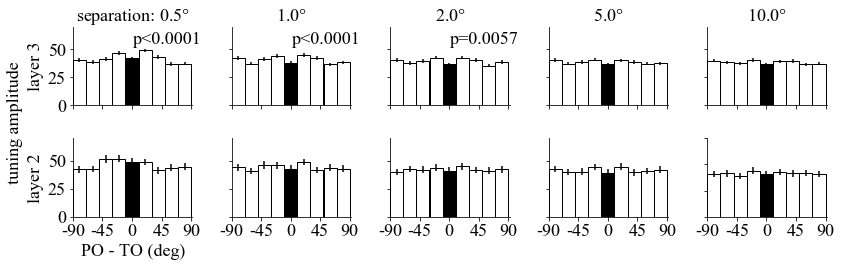

In [21]:
feat1 = 'ori'
feat2 = 'mean'

nbins = 10
bins = np.linspace(-90.1,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[2:0:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('$%.1f\degree$' % diff)
    axes[0,0].set_title('separation: $%.1f\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].A.t[blob][feat2].ptp(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, plot=False,
                                              lw=2.0, color='k', ls = '-');
        ax.bar(bin_centers, map(np.mean, trained_vals), yerr = map(sem, trained_vals), align = 'center', 
               color = bar_colors,  width= 180.0/(nbins-1), ec = 'k')
        
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = dfs[i].B.t[blob][feat2].ptp(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        
        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                                lw=2.0, color='gray', ls='--', plot = False);
        '''
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05:
                ax.plot([bin_centers[bini]], [60], '*', color = 'k')
        '''
        fv, pv = f_oneway(*trained_vals)
        print 'x1: %.5g, %.5g, %d' %( fv, pv, sum(map(len, trained_vals)))
        if 0.0001<pv < 0.01:
            ax.text(0, 55, 'p=%.2g' % pv)
        elif pv<0.0001:
            ax.text(0, 55, 'p<0.0001' % pv)

        ax.set_xlim([-90.0,92.0])
        cool_spines(ax)
        ax.set_ylim(0,70)
        ax.set_yticks([0,25,50,75])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        stats_text = 'F(%d,%d)=%.2f p=%.2g' % (nbins-1,sum(map(len, trained_vals))-nbins,fv, pv)
        stats_table[diff][int(blob[-1])] = stats_text


fig.tight_layout()
fig.tight_layout(rect=[0.02,0.05,1,1])
axes[-1,0].set_xlabel('PO - TO (deg)')
fig.text(0.02, 0.53, 'tuning amplitude', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_7-1.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_7-1.svg', dpi = 300)

In [22]:
stats_table

,0.5,1.0,2.0,5.0,10.0
3,"F(9,2777)=6.94 p=4.4e-09","F(9,2829)=4.00 p=0.0001","F(9,2835)=2.71 p=0.0057","F(9,2835)=1.19 p=0.3","F(9,2833)=1.00 p=0.44"
2,"F(9,1068)=1.70 p=0.095","F(9,1079)=0.72 p=0.67","F(9,1093)=0.26 p=0.98","F(9,1095)=0.44 p=0.9","F(9,1090)=0.19 p=0.99"


x1: 3.621, 0.00033707, 2787
0.5 conv3
x1: 1.8543, 0.063705, 1078
0.5 norm2
x1: 0.66629, 0.72169, 2839
1.0 conv3
x1: 0.99765, 0.43603, 1089
1.0 norm2
x1: 0.68004, 0.70958, 2845
2.0 conv3
x1: 0.19578, 0.99149, 1103
2.0 norm2
x1: 0.60558, 0.77394, 2845
5.0 conv3
x1: 0.70758, 0.68508, 1105
5.0 norm2
x1: 0.14082, 0.99731, 2843
10.0 conv3
x1: 0.16236, 0.99553, 1100
10.0 norm2


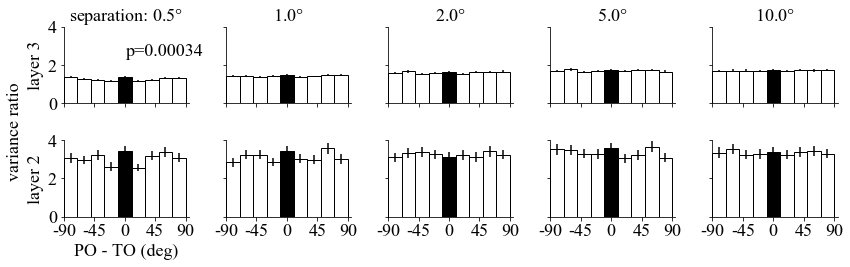

In [23]:
feat1 = 'ori'
feat2 = 'mean'

nbins = 10
bins = np.linspace(-90.1,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[2:0:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('$%.1f\degree$' % diff)
    axes[0,0].set_title('separation: $%.1f\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        ax = axes[bi, di]
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = (dfs[i].A.t[blob]['var'] / ( 0.1 + dfs[i].A.t[blob]['mean'])).mean(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
            
        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, plot=False,
                                              lw=2.0, color='k', ls = '-');
        ax.bar(bin_centers, map(np.mean, trained_vals), yerr = map(sem, trained_vals), align = 'center', 
               color = bar_colors,  width= 180.0/(nbins-1), ec = 'k')
        
        '''
        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat2_vals = 1/dfs[i].B.t[blob][feat2].mean(0)
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, (all_feat1_vals), all_feat2_vals, bins, 
                                                lw=2.0, color='gray', ls='--');
        
        for bini in range(nbins-1):
            F_value, p_value = ttest_ind(trained_vals[bini], untrained_vals[bini])
            if p_value < 0.05:
                ax.plot([bin_centers[bini]], [60], '*', color = 'k')
        print ttest_ind(np.concatenate(trained_vals).flatten(), np.concatenate(untrained_vals).flatten())

        '''
        fv, pv = f_oneway(*trained_vals)
        print 'x1: %.5g, %.5g, %d' %( fv, pv, sum(map(len, trained_vals)))
        if 0.0001<pv < 0.01:
            ax.text(0, 2.5, 'p=%.2g' % pv)
        elif pv<0.0001:
            ax.text(0, 2.5, 'p<0.0001' % pv)
        ax.set_xlim([-90.0,95])
        ax.set_ylim([0,4])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        cool_spines(ax)
        stats_text = 'F(%d,%d)=%.2f p=%.2g' % (nbins-1,sum(map(len, trained_vals))-nbins,fv, pv)
        print diff, blob
        stats_table[diff][int(blob[-1])] = stats_text
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.05,1,1])
axes[-1,0].set_xlabel('PO - TO (deg)')
fig.text(0.01, 0.5, 'variance ratio', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_7-2.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_7-2.svg', dpi = 300)

In [24]:
stats_table

,0.5,1.0,2.0,5.0,10.0
3,"F(9,2777)=3.62 p=0.00034","F(9,2829)=0.67 p=0.72","F(9,2835)=0.68 p=0.71","F(9,2835)=0.61 p=0.77","F(9,2833)=0.14 p=1"
2,"F(9,1068)=1.85 p=0.064","F(9,1079)=1.00 p=0.44","F(9,1093)=0.20 p=0.99","F(9,1095)=0.71 p=0.69","F(9,1090)=0.16 p=1"


In [25]:
stats_table = pd.DataFrame(columns=[0.5,1.0,2.0,5.0, 10.0], index=[5,4])

## V4 Slope at TO

Figure 11,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

conv5 0.5
F(5,196)=3.68, p=0.0033
conv4 0.5
F(5,1244)=12.69, p=4.8e-12
conv5 1.0
F(5,202)=5.33, p=0.00013
conv4 1.0
F(5,1234)=9.48, p=7e-09
conv5 2.0
F(5,203)=8.26, p=4e-07
conv4 2.0
F(5,1220)=5.78, p=2.8e-05
conv5 5.0
F(5,198)=5.61, p=7.4e-05


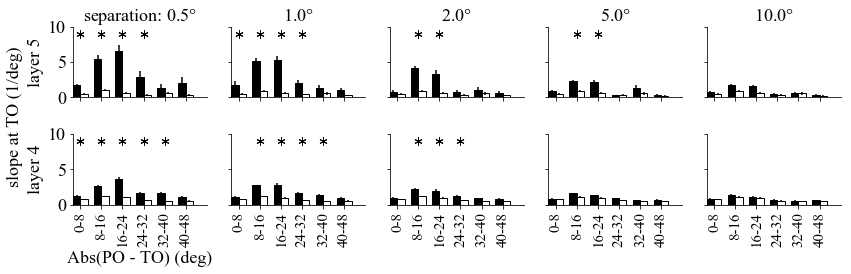

In [26]:
feat1 = 'ori'
feat2 = 'abs_grad'

bins = np.array([0,8,16,24,32,40,48])
#bins = np.array([0,22,45,67,90])

nbins = len(bins)-1

bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
xtickslabels = map(lambda x: '%.0f-%.0f' %(x[0],x[1]), np.c_[bins[:-1],bins[1:]])

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('$%.1f\degree$' % diff)
    axes[0,0].set_title('separation: $%.1f\degree$' % this_diffs[0])


    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])

        for ii, i in enumerate(idx):
            A_common = np.where(dfs[i].A_common[blob])[0]
            feat1_vals = dfs[i].A.t[blob][feat1] - w_df['angle'].iloc[i]
            feat1_vals = feat1_vals[A_common]
            feat2_vals = dfs[i].A.t_test[blob][feat2][A_common]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        _, _, trained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                              lw=2.0, color='r',marker='o', fillstyle = 'none', plot=False);
        trained_mean = map(np.mean, trained_vals)
        trained_sem = map(sem, trained_vals)
        ax.bar(np.arange(nbins)-0.35/2, trained_mean, 0.35, yerr=trained_sem, fc='k', ec='k')

        all_feat1_vals = np.array([])
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            B_common   = np.where(dfs[i].B_common[blob])[0]
            feat1_vals = dfs[i].B.t[blob][feat1] - w_df['angle'].iloc[i]
            feat1_vals = feat1_vals[B_common]
            feat2_vals = dfs[i].B.t_test[blob][feat2][B_common]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1,color='k', alpha = 0.1)    
        _, _, untrained_vals = scatter_errorbar(ax, np.abs(all_feat1_vals), (all_feat2_vals), bins, 
                                                lw=2.0, color='b', ls = '--', marker='o', fillstyle = 'none', 
                                                plot=False);
        untrained_mean = map(np.mean, untrained_vals)
        untrained_sem = map(sem, untrained_vals)
        ax.bar(np.arange(nbins)+0.35/2, untrained_mean, 0.35, yerr=untrained_sem, fc='w', ec='k')
        
        ax.set_ylim([0,10])
        ax.set_yticks([0,5,10])
        ax.set_xlim([-0.35, nbins])
        ax.set_xticks(range(nbins))
        ax.set_xticklabels(xtickslabels, fontsize=15, rotation=90)
        
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        cool_spines(ax)

        slope_df = pd.DataFrame(columns=['slope','bin', 'train'])
        for bini in range(nbins):
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=untrained_vals[bini], train=0)))
            slope_df = slope_df.append(pd.DataFrame(dict(bin=bini, slope=trained_vals[bini], train=1)))
        model = ols('slope ~ C(bin) * (train)', data = slope_df).fit()
        anova_table = sm.stats.anova_lm(model)
        if sm.stats.anova_lm(model)['PR(>F)'].loc['C(bin):train'] < 0.01:
            print blob, diff
            print 'F(%d,%d)=%.2f, p=%.2g' % (anova_table['df']['C(bin):train'],
                                             anova_table['df']['Residual'],
                                             anova_table['F']['C(bin):train'],
                                             anova_table['PR(>F)']['C(bin):train'])
            for bini in range(nbins):
                F_value, p_value = mannwhitneyu(trained_vals[bini], untrained_vals[bini])
                if p_value < 0.01/6:
                    ax.plot([bini], [9], marker=(6,2,0), color = 'k', ms=8)
        stats_text =  'F(%d,%d)=%.2f p=%.2g' % (anova_table['df']['C(bin):train'], 
                                anova_table['df']['Residual'],
                                anova_table['F']['C(bin):train'],
                                anova_table['PR(>F)']['C(bin):train'])
        stats_table[diff][int(blob[-1])] = stats_text
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.03,1,1])
axes[-1,0].set_xlabel('Abs(PO - TO) (deg)')
fig.text(0.01, 0.55, 'slope at TO (1/deg)', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_8-1.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_8-1.svg', dpi = 300)

In [27]:
stats_table[diff_values]

,0.5,1.0,2.0,5.0,10.0
5,"F(5,196)=3.68 p=0.0033","F(5,202)=5.33 p=0.00013","F(5,203)=8.26 p=4e-07","F(5,198)=5.61 p=7.4e-05","F(5,199)=2.79 p=0.018"
4,"F(5,1244)=12.69 p=4.8e-12","F(5,1234)=9.48 p=7e-09","F(5,1220)=5.78 p=2.8e-05","F(5,1215)=1.51 p=0.18","F(5,1224)=0.21 p=0.96"


In [28]:
def test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              text_coords, test_text):

    test_pv = dict()
    print 'layer ' + blob[-1], 'diff: ', diff
    print 'nt= %d, nn = %d, nc = %d\n' % (len(all_feat1_vals), len(all_feat2_vals), len(all_feat1_common))
    
    U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
    print 'U:\n%.2f\n%.2f\n%.3g\n%.3g\n' % (np.median(all_feat2_vals), 
                                        np.median(all_feat1_vals),
                                        U, pv) 
    test_pv['U'] = pv
    d, pv = ks_2samp(all_feat1_vals, all_feat2_vals)
    print 'KS\n%.2g\n%.3g\n' % (d, pv)
    test_pv['ks']=pv
    
    Tv, pv = wilcoxon(all_feat1_common, all_feat2_common)
    print 'W\n%.2f\n%.2f\n%.3g\n%.3g\n' % (np.median(all_feat2_common), 
                                        np.median(all_feat1_common),
                                        Tv, pv) 
    test_pv['W']=pv

    tv, pv = ttest_ind(all_feat1_vals, all_feat2_vals)
    print 't:\n%.2f±%.2f\n%.2f±%.2f\n%.1f\n%.2g\n' % (all_feat2_vals.mean(), 
                                                all_feat2_vals.std(),
                                                all_feat1_vals.mean(),
                                                all_feat1_vals.std(),
                                                tv, pv)
    test_pv['t']=pv

    tv, pv = ttest_rel(all_feat1_common, all_feat2_common)
    print 't2\n%.2f±%.2f\n%.2f±%.2f\n%.3g\n%.2g\n' % (all_feat2_common.mean(), 
                                                all_feat2_common.std(),
                                                all_feat1_common.mean(),
                                                all_feat1_common.std(),
                                                tv, pv)
    test_pv['t2']=pv
    if test_text is not None:
        if 0.0001<test_pv[test_text] < 0.01:
            ax.text(text_coords[0], text_coords[1], '$p=%.2g$' % test_pv[test_text])
        elif test_pv[test_text] < 0.0001:
            ax.text(text_coords[0], text_coords[1], '$p<0.0001$' % test_pv[test_text])

## V4 preferred ori

Figure 5,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

conv5 0.5
d(280)=0.21, p=1.3e-11, 192
X(1,14)=
82.85
8.3e-12

conv4 0.5
d(1334)=0.095, p=6.4e-11, 1203
X(1,14)=
84.8
3.6e-12

conv5 1.0
d(295)=0.21, p=5.2e-12, 192
X(1,14)=
77.38
8.7e-11

conv4 1.0
d(1318)=0.085, p=8e-09, 1203
X(1,14)=
76.72
1.1e-10

conv5 2.0
d(264)=0.15, p=1.7e-05, 192
X(1,14)=
43.62
6.8e-05

conv4 2.0
d(1301)=0.051, p=0.0023, 1203
X(1,14)=
35.58
0.0012

conv5 5.0
d(222)=0.12, p=0.0029, 192
X(1,14)=
26.41
0.023

conv4 5.0
d(1250)=0.029, p=0.24, 1203
X(1,14)=
15.51
0.34

conv5 10.0
d(213)=0.083, p=0.1, 192
X(1,14)=
11.97
0.61

conv4 10.0
d(1230)=0.017, p=0.88, 1203
X(1,14)=
5.244
0.98



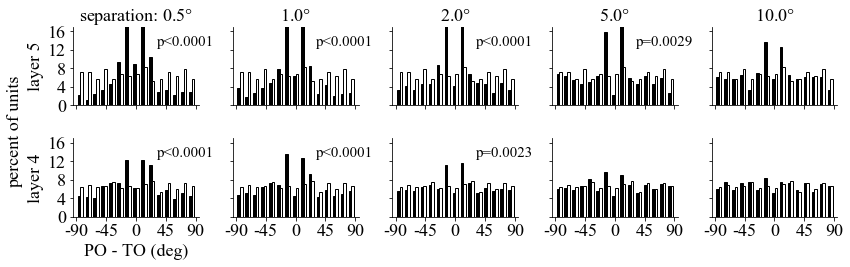

In [29]:
nbins = 16
bins = np.linspace(-90.0,90.1,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)
if ndiff == 1:
    axes = axes[:,None]
bar_colors = ['w' for _ in range(nbins-1)]
bar_colors[nbins/2-1] = 'k'
offset = 180.0 / (nbins-1) / 3
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('$%.1f\degree$' % diff)
    axes[0,0].set_title('separation: $%.1f\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))
        
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            ori = dfs[i].A.t[blob]['mean']
            feat1_vals = np.sin(2*angles*np.pi/180).dot(ori) / np.cos(2*angles*np.pi/180).dot(ori)
            feat1_vals = 1 * np.arctan(feat1_vals) * 180/np.pi
            feat1_vals = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        trained_counts = counts.copy()
        
        ax.bar(bin_centers - offset/2, counts/counts.sum()*100, 
               color = 'k', align='center', ec='k',
               linewidth = 1, width = offset)
            
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            ori = dfs[i].B.t[blob]['mean']
            feat2_vals = np.sin(2*angles*np.pi/180).dot(ori) / np.cos(2*angles*np.pi/180).dot(ori)
            feat2_vals = 1 * np.arctan(feat2_vals) * 180/np.pi
            feat2_vals = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]

            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.bar(bin_centers + offset/2, counts/counts.sum()*100, 
               facecolor = 'w', width = offset,align='center', ec='k',)
        #ax.plot([-diff, -diff],[0,0.25], ':k')
        #ax.plot([diff, diff],[0,0.25], ':k')
        d_value, pv = kstest(all_feat1_vals, 'uniform', args=(-90,180))
        print blob, diff
        print 'd(%d)=%.2g, p=%.2g, %d' % (len(all_feat1_vals), d_value, pv, len(all_feat2_vals))
        stats_text = 'd=%.2g p=%.2g n=%d' % (d_value, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        if 0.0001<pv <0.01:
            ax.text(30, 13, 'p=%.2g' % pv, fontsize=15)
        elif pv < 0.0001:
            ax.text(30, 13, 'p<0.0001', fontsize=15)

            
        x2, pv = chi2_contingency(np.c_[untrained_counts, trained_counts])[:2]
        print 'X(1,%d)=\n%.4g\n%.2g' % (nbins-2, x2, pv)
        print ''
        
        ax.set_ylim([0,17])
        ax.set_xlim([-95,95])
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        ax.set_yticks([0,4,8,12,16])
        cool_spines(ax)

fig.tight_layout()
fig.tight_layout(rect=[0.01,0.05,1,1])
axes[-1,0].set_xlabel('PO - TO (deg)')
fig.text(0.01, 0.5, 'percent of units', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_8-2.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_8-2.svg', dpi = 300)

In [30]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,d=0.21 p=1.3e-11 n=280,d=0.21 p=5.2e-12 n=295,d=0.15 p=1.7e-05 n=264,d=0.12 p=0.0029 n=222,d=0.083 p=0.1 n=213
4,d=0.095 p=6.4e-11 n=1334,d=0.085 p=8e-09 n=1318,d=0.051 p=0.0023 n=1301,d=0.029 p=0.24 n=1250,d=0.017 p=0.88 n=1230


## Selectivity Index of V4

Figure 3,

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. https://doi.org/10.1523/JNEUROSCI.0457-06.2006

layer 5 diff:  0.5
nt= 280, nn = 192, nc = 156

U:
0.55
0.72
2.01e+04
1.74e-06

KS
0.33
3e-11

W
0.26
0.59
3.15e+03
1.49e-07

t:
0.50±0.34
0.66±0.27
5.6
4.7e-08

t2
0.44±0.33
0.55±0.29
5.9
2.3e-08


layer 4 diff:  0.5
nt= 1334, nn = 1203, nc = 1066

U:
0.54
0.60
7.17e+05
2.01e-06

KS
0.1
2.74e-06

W
0.50
0.54
2.34e+05
5.08e-07

t:
0.53±0.27
0.58±0.27
4.5
7.8e-06

t2
0.51±0.27
0.54±0.26
4.94
8.9e-07


layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.55
0.75
2.11e+04
1.11e-06

KS
0.31
3.13e-10

W
0.53
0.55
4.16e+03
1.3e-06

t:
0.50±0.34
0.66±0.28
5.6
3.5e-08

t2
0.46±0.33
0.54±0.30
5.61
8.3e-08


layer 4 diff:  1.0
nt= 1318, nn = 1203, nc = 1111

U:
0.54
0.57
7.4e+05
0.00178

KS
0.071
0.00332

W
0.50
0.54
2.84e+05
0.0211

t:
0.53±0.27
0.56±0.28
2.7
0.0063

t2
0.52±0.27
0.53±0.27
2.68
0.0075


layer 5 diff:  2.0
nt= 264, nn = 192, nc = 182

U:
0.55
0.66
2.07e+04
0.000384

KS
0.24
2.48e-06

W
0.54
0.54
6.49e+03
0.00987

t:
0.50±0.34
0.62±0.31
3.7
0.0002

t2
0.49±0.34
0.53±0.32
3.68
0.0

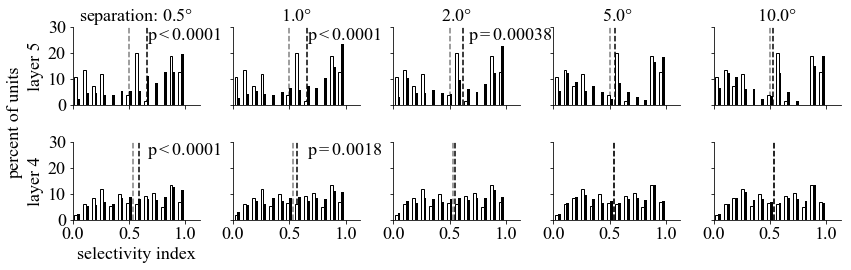

In [31]:
feat1 = 'mean'
nbins = 14
bins = np.linspace(0.0,1.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)
offset = 1.0/(nbins-1)/3
if ndiff == 1:
    axes = axes[:,None]
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('$%.1f\degree$' % diff)
    axes[0,0].set_title('separation: $%.1f\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            fr = dfs[i].A.t[blob]['mean']
            SI = ((np.sin(2*angles*np.pi/180.0).dot(fr))**2 + (np.cos(2*angles*np.pi/180.0).dot(fr))**2)
            SI = np.sqrt(SI)/fr.sum(0)
            feat1_vals = SI
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, align = 'center', color = 'k', width = offset/1)
        untrained_counts = counts.copy()

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            fr = dfs[i].B.t[blob]['mean']
            SI = ((np.sin(2*angles*np.pi/180.0).dot(fr))**2 + (np.cos(2*angles*np.pi/180.0).dot(fr))**2)
            SI = np.sqrt(SI)/fr.sum(0)
            feat2_vals = SI
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        trained_counts = counts.copy()

        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color = 'w', align = 'center', width = offset/1
              , ec='k')
        ax.plot([np.mean(all_feat2_vals),]*2, [0,50], 'gray', ls='--', zorder=0)
        ax.plot([np.mean(all_feat1_vals),]*2, [0,50], '--k', zorder=0)
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]

        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.66,25], 'U')
        
        U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
        stats_text = 'MD=%.2g U=%.2g p=%.2g n=%d' % (np.median(all_feat1_vals), U, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        x2, pv = chi2_contingency(np.c_[untrained_counts, trained_counts]+0.000001)[:2]
        print '============'
        print ''
        ax.set_xlim([0,1+offset*5])
        ax.set_xticks([0,0.5,1.0])
        ax.set_ylim([0,30])
        ax.set_yticks([0,10,20,30])
        cool_spines(ax)
        #ax_xticks(ax, np.arange(0,161,40), np.arange(0,161,40))
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.04,1,1])
axes[-1,0].set_xlabel('selectivity index')
fig.text(0.01, 0.53, 'percent of units', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_8-3.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_8-3.svg', dpi = 300)

In [32]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,MD=0.72 U=2e+04 p=1.7e-06 n=280,MD=0.75 U=2.1e+04 p=1.1e-06 n=295,MD=0.66 U=2.1e+04 p=0.00038 n=264,MD=0.58 U=2e+04 p=0.1 n=222,MD=0.56 U=1.9e+04 p=0.21 n=213
4,MD=0.6 U=7.2e+05 p=2e-06 n=1334,MD=0.57 U=7.4e+05 p=0.0018 n=1318,MD=0.56 U=7.6e+05 p=0.067 n=1301,MD=0.55 U=7.4e+05 p=0.34 n=1250,MD=0.54 U=7.4e+05 p=0.44 n=1230


## Fano 

Table 2 and Fig 3

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. http://doi.org/10.1523/JNEUROSCI.0457-06.2006


layer 5 diff:  0.5
nt= 280, nn = 192, nc = 156

U:
0.45
0.16
1.02e+04
7.31e-31

KS
0.52
2.5e-27

W
0.40
0.13
749
1.93e-21

t:
0.52±0.38
0.23±0.21
-10.7
3.7e-24

t2
0.46±0.32
0.22±0.23
-11.5
1.2e-22

X(1,12)=
146.1
p=3.4e-25
layer 4 diff:  0.5
nt= 1334, nn = 1203, nc = 1066

U:
0.66
0.39
4.87e+05
5.66e-66

KS
0.32
6.01e-58

W
0.63
0.34
7.45e+04
9.45e-97

t:
0.84±0.66
0.55±0.53
-12.3
1.3e-33

t2
0.78±0.58
0.49±0.50
-20.6
9.1e-80

X(1,12)=
371.2
p=4.8e-72
layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.45
0.22
1.58e+04
6.51e-17

KS
0.38
1.29e-15

W
0.42
0.18
1.37e+03
4.59e-20

t:
0.52±0.38
0.31±0.27
-7.2
1.8e-12

t2
0.47±0.33
0.28±0.28
-8.98
5e-16

X(1,12)=
87.4
p=1.6e-13
layer 4 diff:  1.0
nt= 1318, nn = 1203, nc = 1111

U:
0.66
0.46
5.81e+05
2.33e-31

KS
0.24
1.72e-32

W
0.64
0.42
1.08e+05
5.36e-79

t:
0.84±0.66
0.67±0.64
-6.9
8.9e-12

t2
0.80±0.62
0.60±0.61
-16
4.8e-52

X(1,12)=
194.8
p=3.8e-35
layer 5 diff:  2.0
nt= 264, nn = 192, nc = 182

U:
0.45
0.29
1.84e+04
2.68e-07

KS
0.27

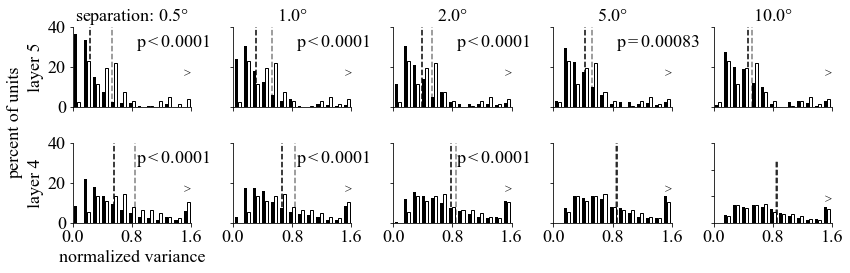

In [33]:
feat1 = 'mean_var'
nbins = 14
bins = np.linspace(0.0,1.6,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
bins[-1] = np.inf

this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = 1.6/(nbins-1)/3

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)
if ndiff == 1:
    axes = axes[:,None]
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            ori = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            feat1_vals = 1/(dfs[i].A.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat1_vals[all_feat1_vals>100] = 100

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        trained_counts = counts.copy()
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color = 'k', width = offset)

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            ori = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            feat2_vals = 1/(0.0 + dfs[i].B.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])            
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat2_vals[all_feat2_vals>100] = 100
        
        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.bar(bin_centers + offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        ax.plot([np.mean(all_feat2_vals),]*2, [0,47,], color = 'gray', ls='--', zorder=0)
        ax.plot([np.mean(all_feat1_vals),]*2, [0,47,], color = 'k', ls='--', zorder=0 )
        cool_spines(ax)
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [0.85,30], 'U')   
        x2, pv = chi2_contingency(np.c_[untrained_counts+1, trained_counts+1])[:2]
        print 'X(1,%d)=\n%.1f\np=%.2g' % (nbins-2, x2, pv)   # number of bins = nbins-1
        U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
        stats_text = 'MD=%.2g U=%.3g p=%.2g n=%d' % (np.median(all_feat1_vals), U, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        print '============='
            
        ax.set_xlim([0.0,1.6])
        ax.set_xticks(np.arange(0.0,1.7,0.8))
        ax.set_ylim([0,40])
        ax.text(1.55, 15,'>',ha='center',fontsize=12)
        #ax_xticks(ax,range(), range(6))
        ax_yticks(ax, np.arange(0,71,20), np.arange(0,71,20))
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.03,1,1])
axes[-1,0].set_xlabel('normalized variance')
fig.text(0.01, 0.53, 'percent of units', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_8-4.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_8-4.svg', dpi = 300)

In [34]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,MD=0.16 U=1.02e+04 p=7.3e-31 n=280,MD=0.22 U=1.58e+04 p=6.5e-17 n=295,MD=0.29 U=1.84e+04 p=2.7e-07 n=264,MD=0.34 U=1.75e+04 p=0.00083 n=222,MD=0.38 U=1.84e+04 p=0.041 n=213
4,MD=0.39 U=4.87e+05 p=5.7e-66 n=1334,MD=0.46 U=5.81e+05 p=2.3e-31 n=1318,MD=0.58 U=6.93e+05 p=3.5e-07 n=1301,MD=0.65 U=7.37e+05 p=0.2 n=1250,MD=0.66 U=7.35e+05 p=0.39 n=1230


layer 3 diff:  0.5
nt= 2787, nn = 2848, nc = 2602

U:
1.62
0.70
3.16e+06
3.89e-41

KS
0.19
5.09e-46

W
1.52
0.67
5.79e+05
3.59e-101

t:
3.91±11.56
3.92±13.86
0.0
0.97

t2
3.82±11.53
3.80±13.71
-0.0527
0.96

X(1,12)=
276.6
p=3.8e-52
layer 2 diff:  0.5
nt= 1078, nn = 1092, nc = 933

U:
2.42
1.55
5.36e+05
0.000135

KS
0.11
2.16e-06

W
2.04
1.30
7.01e+04
9.68e-20

t:
5.88±12.67
4.45±11.36
-2.8
0.0058

t2
5.24±11.34
4.35±11.40
-2.07
0.039

X(1,12)=
45.9
p=7.3e-06
layer 3 diff:  1.0
nt= 2839, nn = 2848, nc = 2689

U:
1.62
1.06
3.65e+06
8.97e-11

KS
0.1
4.34e-13

W
1.56
1.01
8.2e+05
2.38e-52

t:
3.91±11.56
4.19±13.50
0.8
0.4

t2
3.80±11.44
4.06±13.29
0.794
0.43

X(1,12)=
85.4
p=3.9e-13
layer 2 diff:  1.0
nt= 1089, nn = 1092, nc = 976

U:
2.42
2.10
5.69e+05
0.0417

KS
0.065
0.0184

W
2.09
1.75
9.81e+04
2.16e-07

t:
5.88±12.67
5.22±12.35
-1.2
0.22

t2
5.55±12.34
5.08±12.34
-0.994
0.32

X(1,12)=
21.0
p=0.051
layer 3 diff:  2.0
nt= 2845, nn = 2848, nc = 2757

U:
1.62
1.40
3.95e+06
0.0471

KS
0.03

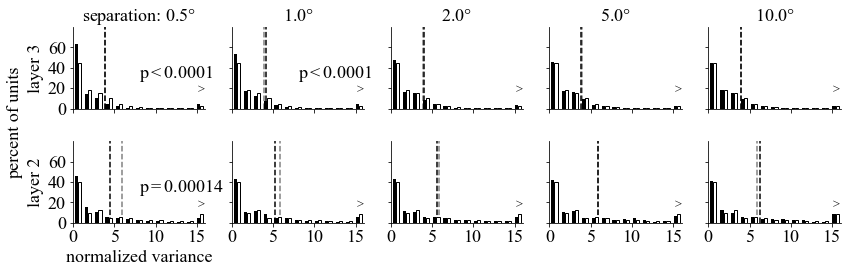

In [35]:
feat1 = 'mean_var'
nbins = 14
bins = np.linspace(0.0,16,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
bins[-1] = np.inf

this_blobs = blobs[2:0:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = bins[-2]/(nbins-1)/3

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)
if ndiff == 1:
    axes = axes[:,None]
for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            ori = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > np.zeros_like(ori), axis=0)
            feat1_vals = 1/(0.01+dfs[i].A.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])
            feat1_vals[feat1_vals>99]=0
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]

            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat1_vals[all_feat1_vals>100] = 100

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        trained_counts = counts.copy()
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color = 'k', width = offset)

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            ori = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > np.zeros_like(ori), axis=0)
            feat2_vals = 1/(0.01 + dfs[i].B.t[blob][feat1][pref_idx, np.arange(len(pref_idx))])            
            feat2_vals[feat2_vals>99]=0
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]
        
        #all_feat1_vals = all_feat1_vals[all_feat1_vals<1000]
        #all_feat2_vals[all_feat2_vals>100] = 100
        
        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.bar(bin_centers + offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        ax.plot([np.mean(all_feat2_vals),]*2, [0,80,], color = 'gray', ls='--', zorder=0)
        ax.plot([np.mean(all_feat1_vals),]*2, [0,80,], color = 'k', ls='--', zorder=0 )
        cool_spines(ax)
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [8,30], 'U')   
        x2, pv = chi2_contingency(np.c_[untrained_counts+1, trained_counts+1])[:2]
        print 'X(1,%d)=\n%.1f\np=%.2g' % (nbins-2, x2, pv)   # number of bins = nbins-1
        U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
        stats_text = 'MD=%.2g U=%.3g p=%.2g n=%d' % (np.median(all_feat1_vals), U, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        print '============='
            
        ax.set_xlim([0.0,16])
        ax.set_xticks(np.arange(0.0,16,5))
        ax.set_ylim([0,80])
        ax.text(15.5, 15,'>',ha='center',fontsize=12)
        #ax_xticks(ax,range(), range(6))
        ax_yticks(ax, np.arange(0,71,20), np.arange(0,71,20))
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.03,1,1])
axes[-1,0].set_xlabel('normalized variance')
fig.text(0.01, 0.53, 'percent of units', va='center', rotation=90)
#fig.savefig(fig_dir + 'reviewer_fig_1.tiff', dpi = 300)
#fig.savefig(fig_dir + 'reviewer_fig_1.svg', dpi = 300)

## Max firing rate
Table 2 in 

Raiguel, S., Vogels, R., Mysore, S. G., & Orban, G. a. (2006). Learning to see the difference specifically alters the most informative V4 neurons. The Journal of Neuroscience : The Official Journal of the Society for Neuroscience, 26(24), 6589–6602. http://doi.org/10.1523/JNEUROSCI.0457-06.2006


layer 4 diff:  1.0
nt= 1318, nn = 1203, nc = 1111

U:
20.25
26.41
6.79e+05
2.64e-10

KS
0.15
2.78e-12

W
23.19
29.41
1.36e+05
1.18e-58

t:
26.70±16.32
32.08±20.70
7.2
8.6e-13

t2
27.89±16.39
34.53±21.11
17.3
1.2e-59

X(1,12)=
118.7
p=1.1e-19

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
14.64
22.49
2.07e+04
2.82e-07

KS
0.27
5.95e-08

W
14.83
37.35
635
5.72e-25

t:
20.52±13.35
32.39±26.79
5.7
2.3e-08

t2
21.62±13.78
42.67±29.70
10.7
7.4e-21

X(1,12)=
43.5
p=1.8e-05

layer 4 diff:  2.0
nt= 1301, nn = 1203, nc = 1148

U:
20.25
23.68
7.25e+05
0.000761

KS
0.089
9.36e-05

W
21.79
26.02
1.72e+05
8.69e-45

t:
26.70±16.32
29.27±18.40
3.7
0.00025

t2
27.45±16.32
31.11±18.55
14.9
6.6e-46

X(1,12)=
58.3
p=4.7e-08

layer 5 diff:  2.0
nt= 264, nn = 192, nc = 182

U:
14.64
21.07
2.04e+04
0.000166

KS
0.22
4.88e-05

W
14.70
29.10
1.08e+03
2.26e-24

t:
20.52±13.35
27.75±20.57
4.2
2.6e-05

t2
21.03±13.51
33.34±21.73
10.1
2.9e-19

X(1,12)=
44.3
p=1.3e-05



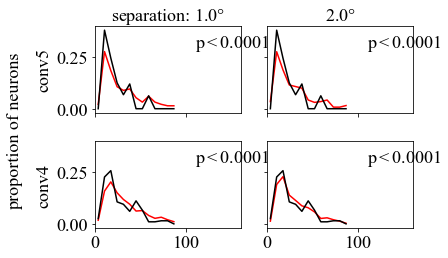

In [36]:
nbins = 14
bins = np.linspace(0.0,90.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[3:5]
this_diffs = [diffs[i] for i in [1,2]]
nblob = len(this_blobs)
ndiff = len(this_diffs)
fig, axes = plt.subplots(nblob, ndiff, figsize=(6,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[nblob-1-bi, di]
        axes[nblob-1-bi, 0].set_ylabel(blob)

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob]['mean'].max(0)
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.plot(bin_centers, counts/counts.sum(), 'r')
        trained_counts = counts.copy()

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat2_vals = dfs[i].B.t[blob]['mean'].max(0)
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        untrained_counts = counts.copy()
        ax.plot(bin_centers, counts/counts.sum(), 'k')
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [110.0,0.3], 'ks')
        
        x2, pv = chi2_contingency(np.c_[untrained_counts, trained_counts])[:2]
        print 'X(1,%d)=\n%.1f\np=%.2g' % (nbins-2, x2, pv)   # number of bins = nbins-1
        print ''
        
        ax.set_xlim([0,160])
        #ax_xticks(ax, np.arange(0,161,40), np.arange(0,161,40))
fig.tight_layout()
fig.tight_layout(rect=[0.03,0.01,1,1])
fig.text(0.5, 0.0, '', ha='center')
fig.text(0.01, 0.5, 'proportion of neurons', va='center', rotation=90)

## Tuning amplitude
Table 1 and fig 5 in 

Yang, T., & Maunsell, J. H. (2004). The effect of perceptual learning on neuronal responses in monkey visual area V4. J.Neurosci., 24(1529-2401), 1617–1626. http://doi.org/10.1523/JNEUROSCI.4442-03.2004

layer 5 diff:  0.5
nt= 280, nn = 192, nc = 156

U:
14.64
25.28
1.54e+04
1.7e-15

KS
0.4
2.35e-16

W
15.59
34.26
385
3.22e-24

t:
17.30±7.59
36.37±33.22
7.8
4.1e-14

t2
18.40±7.88
47.47±38.74
9.98
2.1e-18

layer 4 diff:  0.5
nt= 1334, nn = 1203, nc = 1066

U:
19.79
26.92
6.41e+05
1.06e-18

KS
0.17
9.33e-17

W
23.40
30.66
1.13e+05
5.75e-65

t:
24.67±13.63
32.96±22.59
11.0
9.8e-28

t2
26.16±13.67
36.11±23.23
17.9
4.2e-63

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
14.64
22.09
1.9e+04
4.16e-10

KS
0.38
4.48e-15

W
14.83
34.11
450
2.74e-26

t:
17.30±7.59
31.02±25.63
7.2
2.3e-12

t2
17.99±7.75
40.31±28.69
11.1
9.5e-22

layer 4 diff:  1.0
nt= 1318, nn = 1203, nc = 1111

U:
19.79
25.85
6.64e+05
9.49e-13

KS
0.15
3.13e-13

W
22.88
28.27
1.41e+05
2.28e-55

t:
24.67±13.63
30.28±18.74
8.5
2.4e-17

t2
25.69±13.65
32.41±19.07
17.2
7.7e-59

layer 5 diff:  2.0
nt= 264, nn = 192, nc = 182

U:
14.64
20.77
1.88e+04
1.17e-06

KS
0.3
1.64e-09

W
14.70
26.84
992
6.66e-25

t:
17.30±7.59
25.83±18.46
6

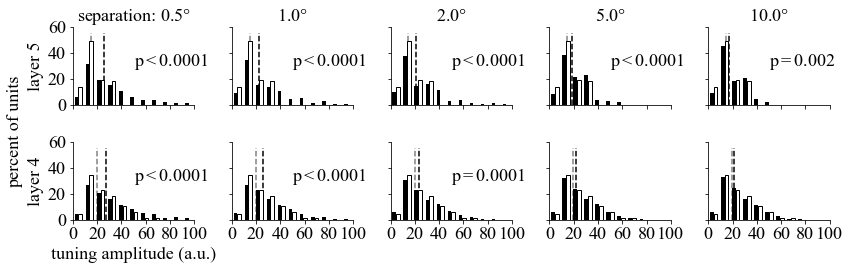

In [37]:
feat1 = 'mean'
nbins = 12
bins = np.linspace(0.0,100.0,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = 100.0/(nbins-1)/3

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))

        feat1_common = np.array([], dtype='bool')
        all_feat1_vals = np.array([])
        for ii, i in enumerate(idx):
            feat1_vals = dfs[i].A.t[blob]['mean'].ptp(0)
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color='k', width = offset)

        feat2_common = np.array([], dtype='bool')
        all_feat2_vals = np.array([])
        for ii, i in enumerate(idx):
            feat2_vals = dfs[i].B.t[blob]['mean'].ptp(0)
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        
        # tests
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [50,30], 'U')
        print '==========='
        ax.set_xlim([0,100])
        ax.set_ylim(0,60)
        ax_yticks(ax, np.arange(0,61,20), np.arange(0,61,20))
        ax_xticks(ax, np.arange(0,101,20), np.arange(0,101,20))

        ax.plot([np.median(all_feat1_vals),]*2, [0,55], '--k', zorder=0 )
        ax.plot([np.median(all_feat2_vals),]*2, [0,55], color = 'gray', ls='--', zorder=0 )
        cool_spines(ax)
        
        U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals)
        stats_text = 'MD=%.2f U=%.3g p=%.2g n=%d' % (np.median(all_feat1_vals), U, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.04,1,1])
axes[-1,0].set_xlabel('tuning amplitude (a.u.)')
fig.text(0.01, 0.5, 'percent of units', va='center', rotation=90)
fig.savefig(fig_dir + 'fig_9-1.tiff', dpi = 300)
fig.savefig(fig_dir + 'fig_9-1.svg', dpi = 300)

In [38]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,MD=0.16 U=1.02e+04 p=7.3e-31 n=280,MD=0.22 U=1.58e+04 p=6.5e-17 n=295,MD=0.29 U=1.84e+04 p=2.7e-07 n=264,MD=0.34 U=1.75e+04 p=0.00083 n=222,MD=0.38 U=1.84e+04 p=0.041 n=213
4,MD=0.39 U=4.87e+05 p=5.7e-66 n=1334,MD=0.46 U=5.81e+05 p=2.3e-31 n=1318,MD=0.58 U=6.93e+05 p=3.5e-07 n=1301,MD=0.65 U=7.37e+05 p=0.2 n=1250,MD=0.66 U=7.35e+05 p=0.39 n=1230


## Best discriminability

layer 5 diff:  0.5
nt= 280, nn = 192, nc = 156

U:
0.80
0.08
8.08e+03
1.9e-38

KS
0.55
5.27e-31

W
0.85
0.11
1.21e+03
3.48e-18

t:
1.02±0.80
0.29±0.52
-11.9
8.1e-29

t2
1.06±0.81
0.36±0.56
-9.61
2e-17

layer 4 diff:  0.5
nt= 1334, nn = 1203, nc = 1066

U:
1.53
0.27
4.19e+05
2.28e-96

KS
0.34
1.98e-63

W
1.60
0.33
6.6e+04
1.41e-104

t:
2.52±4.60
0.92±2.10
-11.4
1.4e-29

t2
2.40±3.86
0.97±2.16
-13.9
1.3e-40

layer 5 diff:  1.0
nt= 295, nn = 192, nc = 170

U:
0.80
0.11
9.48e+03
1.14e-35

KS
0.51
1.81e-27

W
0.83
0.17
1.12e+03
1.08e-21

t:
1.02±0.80
0.31±0.46
-12.3
1.7e-30

t2
1.06±0.81
0.36±0.44
-11
1.5e-21

layer 4 diff:  1.0
nt= 1318, nn = 1203, nc = 1111

U:
1.53
0.46
5.13e+05
2.23e-53

KS
0.25
9.18e-36

W
1.58
0.57
1.1e+05
8.75e-77

t:
2.52±4.60
1.29±2.61
-8.4
1.1e-16

t2
2.53±4.55
1.36±2.70
-11.3
5.7e-28

layer 5 diff:  2.0
nt= 264, nn = 192, nc = 182

U:
0.80
0.33
1.46e+04
4.79e-15

KS
0.34
6.8e-12

W
0.83
0.41
3.32e+03
2e-12

t:
1.02±0.80
0.56±0.75
-6.2
1.3e-09

t2
1.04±0.80
0.64±0

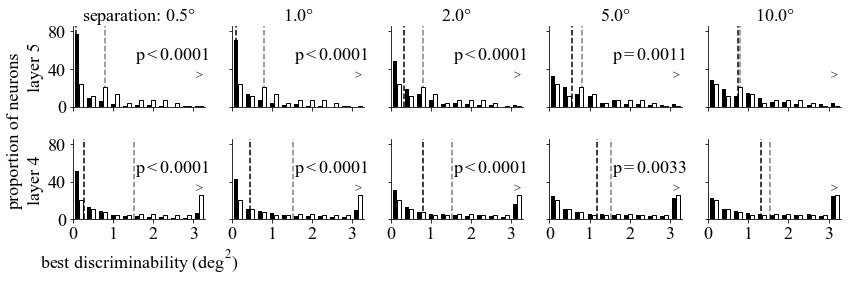

In [39]:
feat1 = 'mean'
nbins = 12
bins = np.linspace(0.0,3.3,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = bins.max()/(nbins-1)/3
bins[-1]=np.inf

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))
        ax = axes[bi, di]

        all_feat1_vals = np.array([])
        feat1_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat1_vals = 1/np.max(dfs[i].A.t[blob]['abs_grad']**2/dfs[i].A.t[blob]['var'],0)
            feat1_common = np.r_[feat1_common, dfs[i].A_common[blob]]
            all_feat1_vals = np.r_[all_feat1_vals, feat1_vals]

        #ax.scatter(all_feat1_vals, all_feat2_vals, s=1, color = 'r', alpha = 0.3)    
        #ax.set_ylim([0,0.0013])
        counts = np.histogram(all_feat1_vals, bins)[0].astype('float')
        ax.bar(bin_centers-offset/2, counts/counts.sum()*100, color='k', width = offset)

        all_feat2_vals = np.array([])
        feat2_common = np.array([], dtype='bool')
        for ii, i in enumerate(idx):
            feat2_vals = 1/np.max(dfs[i].B.t[blob]['abs_grad']**2/dfs[i].B.t[blob]['var'],0)
            feat2_common = np.r_[feat2_common, dfs[i].B_common[blob]]
            all_feat2_vals = np.r_[all_feat2_vals, feat2_vals]

        counts = np.histogram(all_feat2_vals, bins)[0].astype('float')
        ax.bar(bin_centers+offset/2, counts/counts.sum()*100, color = 'w', width = offset, ec='k')
        
        all_feat1_common = all_feat1_vals[feat1_common]
        all_feat2_common = all_feat2_vals[feat2_common]
        test_dist(blob, diff, all_feat1_vals, all_feat2_vals, 
              all_feat1_common, all_feat2_common, 
              [1.55,50], 'U')
        ax.set_xlim([0,3.3])
        ax.set_ylim(0,85)
        ax_yticks(ax, np.arange(0,85,40), np.arange(0,85,40))
        ax.text(3.15, 30,'>',ha='center',fontsize=12)
        ax.set_xticks([0,1,2,3])
        
        ax.plot([np.median(all_feat1_vals),]*2, [0,100], '--k', zorder=0 )
        ax.plot([np.median(all_feat2_vals),]*2, [0,100], color = 'gray' , ls='--', zorder=0)
        cool_spines(ax)
        
        U, pv = mannwhitneyu(all_feat1_vals, all_feat2_vals, alternative='less')
        stats_text = 'MD=%.2f U=%.3g p=%.2g n=%d' % (np.median(all_feat1_vals), U, pv, len(all_feat1_vals))
        stats_table[diff][int(blob[-1])] = stats_text
        
        
fig.tight_layout()
fig.tight_layout(rect=[0.01,0.04,1,1])
axes[-1,0].set_xlabel('best discriminability (deg$^2$)')
fig.text(0.01, 0.5, 'proportion of neurons', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_9-2.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_9-2.svg', dpi = 300)

In [40]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,MD=0.16 U=1.02e+04 p=7.3e-31 n=280,MD=0.22 U=1.58e+04 p=6.5e-17 n=295,MD=0.29 U=1.84e+04 p=2.7e-07 n=264,MD=0.34 U=1.75e+04 p=0.00083 n=222,MD=0.38 U=1.84e+04 p=0.041 n=213
4,MD=0.39 U=4.87e+05 p=5.7e-66 n=1334,MD=0.46 U=5.81e+05 p=2.3e-31 n=1318,MD=0.58 U=6.93e+05 p=3.5e-07 n=1301,MD=0.65 U=7.37e+05 p=0.2 n=1250,MD=0.66 U=7.35e+05 p=0.39 n=1230


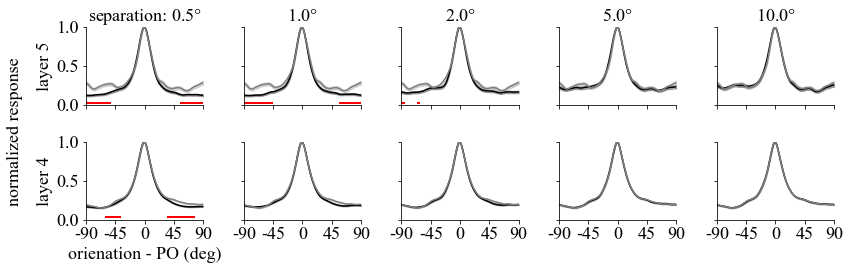

In [41]:
feat1 = 'mean'
nbins = 13
bins = np.linspace(0.0,1.6,nbins)
bin_centers = (bins[1:]+bins[:-1])/2.0
this_blobs = blobs[4:2:-1]
this_diffs = diffs
nblob = len(this_blobs)
ndiff = len(this_diffs)
offset = bins.max()/(nbins-1)/3
bins[-1]=np.inf

fig, axes = plt.subplots(nblob, ndiff, figsize=(12,4), sharex = True, sharey = True)

for di, diff in enumerate(this_diffs):
    _, idx = lookup(w_df, noise = 15.0, wave = 10.0, ctrst = 0.2, d_angle = diff)
    axes[0,di].set_title('%.1f$\degree$' % diff)
    axes[0,0].set_title('separation: %.1f$\degree$' % this_diffs[0])
    for bi, blob in enumerate(this_blobs):
        
        ax = axes[bi, di]
        axes[bi, 0].set_ylabel('layer ' + str(blob[-1]))
        all_feat1_vals = np.zeros((nangle, 0))
        for ii, i in enumerate(idx):

            ori = dfs[i].A.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            tc = dfs[i].A.t[blob]['mean'].copy()
            
            for ni in range(tc.shape[1]):
                tc[:,ni] = np.roll(tc[:,ni],50-pref_idx[ni])/tc[:,ni].max()

            all_feat1_vals = np.c_[all_feat1_vals, tc]

        plot_env(ax, angles, all_feat1_vals.mean(1), all_feat1_vals.std(1), 
                std_scale=np.sqrt(all_feat1_vals.shape[1]), color='k')
    
        all_feat2_vals = np.zeros((nangle, 0))
        for ii, i in enumerate(idx):

            ori = dfs[i].B.t[blob]['ori'] - w_df['angle'].iloc[i]
            pref_idx = np.argmax(angles[:,None] > ori, axis=0)
            tc = dfs[i].B.t[blob]['mean'].copy()
            
            for ni in range(tc.shape[1]):
                tc[:,ni] = np.roll(tc[:,ni],50-pref_idx[ni])/tc[:,ni].max()

            all_feat2_vals = np.c_[all_feat2_vals, tc]

        plot_env(ax, angles, all_feat2_vals.mean(1), all_feat2_vals.std(1), 
                std_scale=np.sqrt(all_feat2_vals.shape[1]), color='gray')

        # tests
        cool_spines(ax)
        ax_xticks(ax, [-90,-45,0,45,90], [-90,-45,0,45,90])
        ax.set_yticks([0,0.5,1.0])
        ax.set_ylim([0,1.0])
        
        prefer_nonprefer = np.c_[all_feat1_vals[25:75,:].mean(0), all_feat1_vals.sum(0)-all_feat1_vals[25:75,:].mean(0)]
        tuning_df1 = pd.melt(pd.DataFrame(prefer_nonprefer), var_name='angle', value_name='tuning')
        tuning_df1['train']=1

        
        prefer_nonprefer = np.c_[all_feat2_vals[25:75,:].mean(0), all_feat2_vals.sum(0)-all_feat2_vals[25:75,:].mean(0)]
        tuning_df2 = pd.melt(pd.DataFrame(prefer_nonprefer), var_name='angle', value_name='tuning')
        tuning_df2['train']=0

        tuning_df = pd.concat([tuning_df1, tuning_df2])

        model = ols('tuning ~ C(angle) * C(train)', data = tuning_df).fit()
        anova_table = sm.stats.anova_lm(model)
        
        stats_text = 'F(1,%d)=%.2f p=%.2g' % (anova_table['df']['Residual'],
                                        anova_table['F']['C(angle):C(train)'],
                                        anova_table['PR(>F)']['C(angle):C(train)'])
        if anova_table['PR(>F)']['C(angle):C(train)']<0.01:
            for i in range(99):
                if mannwhitneyu(all_feat1_vals[i], all_feat2_vals[i], alternative='less')[1]<0.01/100:
                    ax.plot([angles[i]-0.8,angles[i]+0.8],[0.03,0.03],color='r', lw=2)
        stats_table[diff][int(blob[-1])] = stats_text
        ax.set_xlim([-90,90])
fig.tight_layout()
fig.tight_layout(rect=[0.02,0.04,1,1])
axes[-1,0].set_xlabel('orienation - PO (deg)')
fig.text(0.01, 0.5, 'normalized response', va='center', rotation=90)
#fig.savefig(fig_dir + 'fig_9-3.tiff', dpi = 300)
#fig.savefig(fig_dir + 'fig_9-3.svg', dpi = 300)

In [43]:
stats_table

,0.5,1.0,2.0,5.0,10.0
5,MD=0.16 U=1.02e+04 p=7.3e-31 n=280,MD=0.22 U=1.58e+04 p=6.5e-17 n=295,MD=0.29 U=1.84e+04 p=2.7e-07 n=264,MD=0.34 U=1.75e+04 p=0.00083 n=222,MD=0.38 U=1.84e+04 p=0.041 n=213
4,MD=0.39 U=4.87e+05 p=5.7e-66 n=1334,MD=0.46 U=5.81e+05 p=2.3e-31 n=1318,MD=0.58 U=6.93e+05 p=3.5e-07 n=1301,MD=0.65 U=7.37e+05 p=0.2 n=1250,MD=0.66 U=7.35e+05 p=0.39 n=1230
